In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from IPython.display import display, clear_output

class my_pca:
    def __init__(self, data):
        # Normalisation des données
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        data = pd.DataFrame(
            data_scaled,
            index=data.index,
            columns=data.columns
        )

        # Application de l'ACP
        pca = PCA()
        data_pca = pca.fit_transform(data_scaled)
        data_pca = pd.DataFrame(
            data_pca,
            columns=[f'PC{x}' for x in range(1, data_pca.shape[1]+1)]
        )

        self.data = data
        self.data_pca = data_pca
        self.pca = pca

    def eigenval_plot(self):
        plt.figure(figsize=(8,5))
        plt.bar(range(1, len(self.pca.explained_variance_ratio_)+1), self.pca.explained_variance_ratio_, color='blue', alpha=0.7)
        plt.xlabel("Factors")
        plt.ylabel("Percentage of Inertia")
        plt.title("Eigenvalues histogram")
        plt.xticks(np.arange(1, len(self.pca.explained_variance_ratio_)+1, step=1))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    def var_plot(self):
        # Conteneur d'affichage
        output = widgets.Output()

        # Widgets pour sélectionner la colonne de couleur
        show_color = widgets.Checkbox(value=False, description='Show color')
        color_column_widget = widgets.Dropdown(
            options=[(col, col) for col in self.data.columns],
            value=self.data.columns[0],
            description='Column color:'
        )

        # Fonction de mise à jour du graphique
        def update_plot(*_):
            with output:
                clear_output(wait=True)
                pc_x, pc_y = pc_x_widget.value - 1, pc_y_widget.value - 1 
                fig, ax = plt.subplots(figsize=(fig_size_widget.value, fig_size_widget.value))
                
                # Dégradé de couleur selon une colonne spécifique
                cmap = plt.get_cmap('RdBu')
                color_column = color_column_widget.value if show_color.value else None
                
                if color_column is not None:
                    color_values = self.data[color_column]
                    norm = plt.Normalize(color_values.min(), color_values.max())
                else:
                    color_values = None
                    norm = None
                
                # Ajouter les points colorés en fonction de la valeur dans color_column
                if show_point.value:
                    if color_values is not None:
                        scatter = ax.scatter(
                            self.data_pca.iloc[:, pc_x], self.data_pca.iloc[:, pc_y], 
                            c=color_values, cmap='RdBu', norm=norm, edgecolors='k'
                        )
                        cbar = plt.colorbar(scatter, ax=ax)
                        cbar.ax.tick_params(labelsize=6, width=0.5)  # Réduire la taille de la légende
                        cbar.set_label(color_column, fontsize=9)
                    else:
                        ax.scatter(self.data_pca.iloc[:, pc_x], self.data_pca.iloc[:, pc_y], color='blue', edgecolors='k', alpha=0.7)
                    
                    if show_point_labels.value:
                        for i, txt in enumerate(self.data.index):
                            x, y = self.data_pca.iloc[i, pc_x], self.data_pca.iloc[i, pc_y]
                            ax.text(x, y, txt, fontsize=9, ha='right')
                
                # Cercle unité
                ax.add_artist(plt.Circle((0, 0), 1, color='gray', linestyle='--', fill=False))
                
                # Flèches des variables
                correlations = self.pca.components_.T * np.sqrt(self.pca.explained_variance_)
                for i in range(correlations.shape[0]):
                    x, y = correlations[i, pc_x], correlations[i, pc_y]
                    plt.arrow(0, 0, x, y, color='red', alpha=0.7, head_width=0.04, head_length=0.04)
                    if show_vector_labels.value:
                        plt.text(x, y, self.data.columns[i], fontsize=10, ha='center', va='center')

                # Ajustements visuels pour se focaliser sur [-axis_limit, axis_limit]
                ax.set_xlim(-axis_limit_widget.value, axis_limit_widget.value)
                ax.set_ylim(-axis_limit_widget.value, axis_limit_widget.value)
                ax.set_xlabel(f'PC{pc_x+1}')
                ax.set_ylabel(f'PC{pc_y+1}')
                ax.set_title('Variable plots (PCA)')
                ax.set_aspect('equal')
                plt.axhline(0, color='grey', linestyle='--')
                plt.axvline(0, color='grey', linestyle='--')
                plt.grid(False)
                plt.show()

        # Widgets pour sélectionner les composantes principales
        pc_x_widget = widgets.IntSlider(value=1, min=1, max=self.pca.n_components_, description='PC X:')
        pc_y_widget = widgets.IntSlider(value=2, min=1, max=self.pca.n_components_, description='PC Y:')
        show_point = widgets.Checkbox(value=False, description='Show points')
        show_point_labels = widgets.Checkbox(value=False, description='Show point labels')
        show_vector_labels = widgets.Checkbox(value=False, description='Show vector labels')
        fig_size_widget = widgets.IntSlider(value=10, min=8, max=14, description='Figure length')
        axis_limit_widget = widgets.IntSlider(value=2, min=1, max=40, description='Axis limit')

        # Liaison des widgets
        for widget in (pc_x_widget, pc_y_widget, show_point, show_point_labels, show_vector_labels, fig_size_widget, axis_limit_widget, show_color, color_column_widget):
            widget.observe(update_plot, names='value')

        # Affichage
        display(widgets.VBox([pc_x_widget, pc_y_widget, show_point, show_point_labels, show_vector_labels, fig_size_widget, axis_limit_widget, show_color, color_column_widget]), output)
        update_plot()

In [2]:
import pandas as pd
import yfinance as yf 
import os

In [9]:
benchmark = pd.read_csv(os.getcwd()+'/CAC 40 - 2024.csv', index_col='Ticker')

In [26]:
history = pd.DataFrame()
for ticker in benchmark.index:
    history[ticker] = yf.Ticker(ticker).history('10y')['Close']

In [34]:
freq = 'M'

returns = history.resample(freq).last().pct_change(fill_method=None).dropna()

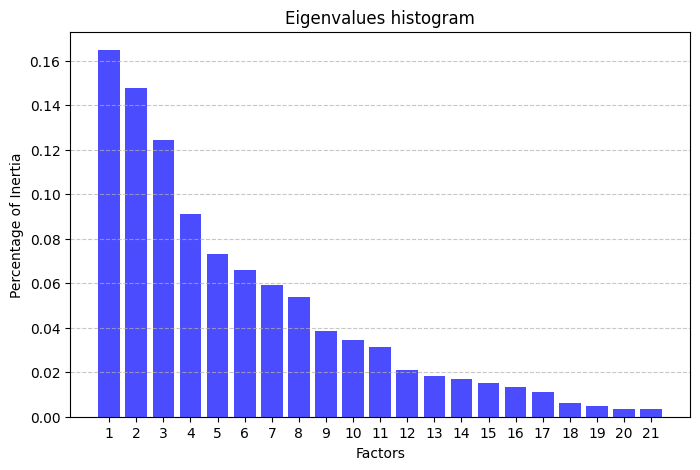

In [35]:
my_pca(returns.T).eigenval_plot()

In [36]:
my_pca(returns.T).var_plot()

Output()

In [41]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [53]:
data = returns.T

kmeans = KMeans(
    n_clusters = 4,
    init = 'random',
    n_init= 'auto',
    max_iter=300,
    
)

kmeans = kmeans.fit(data)

centers = kmeans.cluster_centers_
labels = kmeans.labels_

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Retrieve cluster centers and labels
centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Plot the data points and color them by their cluster
plt.figure(figsize=(8, 6))
for cluster_id in range(kmeans.n_clusters):
    # Plot each cluster's points
    cluster_points = data[labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}')

# Plot the cluster centers
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, marker='X', label='Centers')

# Add legend and title
plt.legend()
plt.title("KMeans Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

InvalidIndexError: (slice(None, None, None), 0)

<Figure size 800x600 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Replace this with your dataset
X = data.T

# Define the number of clusters
n_clusters = 4

# Fit KMeans to your data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_kmeans = kmeans.fit_predict(X)

# Plot the results
plt.figure(figsize=(8, 6))

# Scatter plot of data points, colored by their cluster
for i in range(n_clusters):
    cluster_points = X[y_kmeans == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}', alpha=0.6)

# Plot the cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, label='Centers', marker='X', edgecolor='black')

plt.title("KMeans Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

InvalidIndexError: (slice(None, None, None), 0)

<Figure size 800x600 with 0 Axes>